### Deterministic Environment

In [1]:
import numpy as np
import random

class ContextualDeterministicEnv():
    
    ## Set class attributes such as context_dim and n_arms
    def __init__(self, context_dim_in, n_arms_in):
        self.context_dim = context_dim_in
        self.n_arms = n_arms_in
        self.reward = 1
      
    
    ## Generate a new context each time this method is called
    ## This is set as a state here in this class
    ## number of actions is the number of arms
    def get_context(self) -> np.ndarray:
        self.current_context = random.randint(0, self.n_arms-1)
        return np.array([self.current_context]).reshape(1, 1)
        #return(self.current_context)
    
    
    ## Set the logic for the correct action for a context
    ## Dictionary {(0,0): 0, (0,1): 2, (1,0): 3, (1,1): 4 }
    def set_context_action_mapping(self, context_action_mapping) -> None:
        self.context_action_mapping = context_action_mapping
        
        
    ## Given an action get the reward for that action for the current context
    ## Convert numpy array to tuple as tuple(map(tuple, arr))
    def get_reward(self, action: int, context: np.ndarray) -> float:
        if(self.context_action_mapping[str(context)] == action):
            return self.reward
        else:
            return 0

        
    def get_num_arms(self) -> int:
        return self.n_arms

    
    def get_context_dim(self) -> int:
        return self.context_dim

### Stochastic Environment

In [107]:
import numpy as np
import random

class ContextualStochasticRewardsEnv():
    
    ## Set class attributes such as context_dim and n_arms
    def __init__(self, context_dim_in, n_arms_in, reward_probability):
        self.context_dim = context_dim_in
        self.n_arms = n_arms_in
        self.reward_probability = reward_probability
        self.reward = 1.0 / self.reward_probability
      
    
    ## Generate a new context each time this method is called
    ## This is set as a state here in this class
    ## number of actions is the number of arms
    def get_context(self) -> np.ndarray:
        self.current_context = random.randint(0, self.n_arms-1)
        return np.array([self.current_context]).reshape(1, 1)
        #return(self.current_context)
    
    
    ## Set the logic for the correct action for a context
    ## Dictionary {(0,0): 0, (0,1): 2, (1,0): 3, (1,1): 4 }
    def set_context_action_mapping(self, context_action_mapping) -> None:
        self.context_action_mapping = context_action_mapping
        
        
    ## Given an action get the reward for that action for the current context
    ## Convert numpy array to tuple as tuple(map(tuple, arr))
    def get_reward(self, action: int, context: np.ndarray) -> float:
        random_draw = random.uniform(0,1)
        if(random_draw > self.reward_probability):
            return 0
        else:
            if(self.context_action_mapping[str(context)] == action):
                return self.reward
            else:
                return 0

        
    def get_num_arms(self) -> int:
        return self.n_arms

    
    def get_context_dim(self) -> int:
        return self.context_dim

In [101]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from sklearn.exceptions import NotFittedError


class ThompsonSampling:

    def __init__(self, c_env: ContextualDeterministicEnv, n_models: int, num_steps: int, training_freq: int):
        self.num_arms = c_env.get_num_arms()
        self.num_steps = num_steps
        self.n_models = n_models
        self.training_freq = training_freq
        self.classifiers = [[LogisticRegression() for i in range(self.num_arms)] for j in range(self.n_models)]
        context_dim = c_env.get_context_dim()
        self.context_data = np.zeros((num_steps, context_dim))
        self.rewards_data = np.full((num_steps, self.num_arms), -1, dtype=float)
        self.c_env = c_env
        
    
    ## Sample a context, generate an action based on an action policy such as epsilon greedy which in turn uses
    ## a model that was fit on data(1). Get a reward from this action. Use this reward to update the model by
    ## fitting for reward and context
    def simulate(self) -> np.ndarray:
        """Returns rewards per step"""

        rewards_history = np.zeros(self.num_steps)
        for step in range(self.num_steps):
            ## Generate a context
            context = self.c_env.get_context()
            ## Get the action for the context based on the policy, this is the epsilon greedy action policy here
            ## exploitation is based on the model that is fit in an online fashion
            action = self.action_policy(context)
            ## Get the reward given the action that was selected for the context
            reward = self.c_env.get_reward(action, context)
            rewards_history[step] = reward
            self.save_step(context, action, reward, step)
            if step % self.training_freq == 0:
                self.fit(step)
        
        return rewards_history

    
    def bootstrap_sample(self, contexts, rewards):
        sampled_indices = np.random.randint(0, len(contexts), size=len(contexts))
        bootstrap_contexts = contexts[sampled_indices]
        bootstrap_rewards = rewards[sampled_indices]
        return(bootstrap_contexts, bootstrap_rewards)
        
    
    def fit_classifier(self, contexts: np.ndarray, rewards: np.ndarray, model_index: int) -> None:
        for arm in range(self.num_arms):
            arm_rewards = rewards[:, arm]
            # get the index of the rewards that the arm saw
            index = np.argwhere(arm_rewards != -1)
            index = index.flatten()
            arm_rewards = arm_rewards[index]
            # test if the arm saw at least one example of 
            # each class
            if len(np.unique(arm_rewards)) == 2:
                arm_contexts = contexts[index]
                self.classifiers[model_index][arm].fit(arm_contexts, arm_rewards)

            
    def fit(self, step: int) -> None:
        step += 1
        contexts_so_far = self.context_data[:step]
        rewards_so_far = self.rewards_data[:step]
        for model_index in range(self.n_models):
            bootstrap_contexts, bootstrap_rewards = self.bootstrap_sample(contexts_so_far, rewards_so_far)
            self.fit_classifier(contexts_so_far, rewards_so_far, model_index)
            
            
    def thompson_sampling(self, context: np.ndarray, selected_classifier) -> int:
        rewards = np.zeros(len(selected_classifier))
        for index, classifier in enumerate(selected_classifier):
            try:
                context = context.reshape(1, -1)
                action_score = classifier.predict_proba(context)[0][1]
                #action_score = classifier.predict(context)
            except NotFittedError as e:
                a = 3.0/self.num_arms
                action_score = np.random.beta(a, 4)
            rewards[index] = action_score
        
        max_rewards = max(rewards)
        best_actions = np.argwhere(rewards == max_rewards)
        best_actions = best_actions.flatten()
        if len(best_actions) > 1:
            return np.random.choice(best_actions)
        else:
            return(best_actions)
    
    
    
    def action_policy(self, context: np.ndarray) -> int: 
        model_selected = random.randint(0, self.n_models - 1) 
        action = self.thompson_sampling(context, self.classifiers[model_selected])
        return action

    
    def save_step(self, context: np.ndarray, action: int, reward: float, step: int) -> None:
        #print("Action ",action)
        self.context_data[step] = context
        self.rewards_data[step, action] = reward


### Deterministic Binary


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 97/100 [20:19<00:37, 12.57s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 99/100 [07:11<00:04,  4.37s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:15<00:00,  4.36s/it]

True


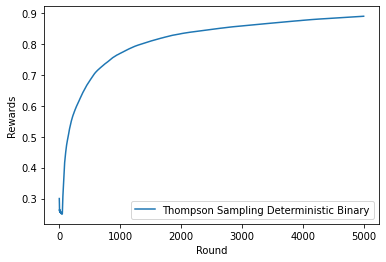

In [142]:
from matplotlib import pyplot as plt 

num_steps = 5000
num_iterations = 100
n_arms = 4
n_models = 3

environment = ContextualDeterministicEnv(context_dim_in=1, n_arms_in=n_arms)
#environment.set_context_action_mapping({'[[0]]':0, '[[1]]':1})
environment.set_context_action_mapping({'[[0]]':0, '[[1]]':1, '[[2]]':2, '[[3]]':3})

## rewards is num_steps x bandit_index x num_iterations 
pbar = tqdm(total=num_iterations)
rewards = np.zeros((num_steps, num_iterations))

for iteration in range(num_iterations):
    bandits = ThompsonSampling(environment, n_models, num_steps, 50)
    rewards[:, iteration] = bandits.simulate()
    pbar.update(1)
pbar.close()

def get_mean_rewards(rewards: np.ndarray) -> np.ndarray:
    bandit_rewards = rewards[:, :]
    bandit_rewards = np.mean(bandit_rewards, axis=1)
    cumulative_rewards = np.zeros_like(bandit_rewards)
    mean_rewards = np.zeros_like(bandit_rewards)
    for index in range(len(bandit_rewards)):
        mean_rewards[index] = np.mean(bandit_rewards[:index+1])
       
    for index, reward in enumerate(bandit_rewards):
        if(index == 0):
            cumulative_rewards[index] = reward
        else:
            cumulative_rewards[index] = (cumulative_rewards[index - 1]*(index) + reward) / (index + 1)
        
    return mean_rewards, cumulative_rewards

mean_rewards, cumulative_rewards = get_mean_rewards(rewards)
print(np.allclose(mean_rewards, cumulative_rewards))

filename = f"Thompson_Deterministic_{n_arms}_{n_models}"
np.save(file=filename, arr=mean_rewards)

labels = ["Thompson Sampling Deterministic Binary"]
plt.plot(mean_rewards, label=labels[0])
plt.ylabel("Rewards")
plt.xlabel("Round")
plt.legend()

### Stochastic Binary

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:07<00:00,  7.88s/it]

True


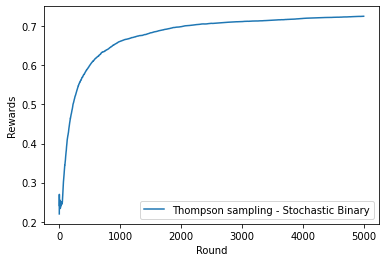

In [140]:
from matplotlib import pyplot as plt 

num_steps = 5000
num_iterations = 100
n_arms = 4
n_models = 7

environment = ContextualStochasticRewardsEnv(context_dim_in=1, n_arms_in=n_arms, reward_probability=0.5)
#environment.set_context_action_mapping({'[[0]]':0, '[[1]]':1})
environment.set_context_action_mapping({'[[0]]':0, '[[1]]':1, '[[2]]':2, '[[3]]':3})

## rewards is num_steps x bandit_index x num_iterations 
pbar = tqdm(total=num_iterations)
rewards = np.zeros((num_steps, num_iterations))

for iteration in range(num_iterations):
    bandits = ThompsonSampling(environment, n_models, num_steps, 50)
    rewards[:, iteration] = bandits.simulate()
    pbar.update(1)
pbar.close()

def get_mean_rewards(rewards: np.ndarray) -> np.ndarray:
    bandit_rewards = rewards[:, :]
    bandit_rewards = np.mean(bandit_rewards, axis=1)
    cumulative_rewards = np.zeros_like(bandit_rewards)
    mean_rewards = np.zeros_like(bandit_rewards)
    for index in range(len(bandit_rewards)):
        mean_rewards[index] = np.mean(bandit_rewards[:index+1])
       
    for index, reward in enumerate(bandit_rewards):
        if(index == 0):
            cumulative_rewards[index] = reward
        else:
            cumulative_rewards[index] = (cumulative_rewards[index - 1]*(index) + reward) / (index + 1)
        
    return mean_rewards, cumulative_rewards

mean_rewards, cumulative_rewards = get_mean_rewards(rewards)
print(np.allclose(mean_rewards, cumulative_rewards))

filename = f"Thompson_Stochastic_{n_arms}_{n_models}"
np.save(file=filename, arr=mean_rewards)

labels = ["Thompson sampling - Stochastic Binary"]
plt.plot(mean_rewards, label=labels[0])
plt.ylabel("Rewards")
plt.xlabel("Round")
plt.legend()

In [95]:
bandits = ThompsonSampling(environment, 10, num_steps, 50)
bandits.classifiers

[[LogisticRegression(), LogisticRegression()],
 [LogisticRegression(), LogisticRegression()],
 [LogisticRegression(), LogisticRegression()],
 [LogisticRegression(), LogisticRegression()],
 [LogisticRegression(), LogisticRegression()],
 [LogisticRegression(), LogisticRegression()],
 [LogisticRegression(), LogisticRegression()],
 [LogisticRegression(), LogisticRegression()],
 [LogisticRegression(), LogisticRegression()],
 [LogisticRegression(), LogisticRegression()]]

In [117]:
filename = f"Thompson_Stochastic_{n_arms}_{n_models}"
np.save(file=filename, arr=mean_rewards)

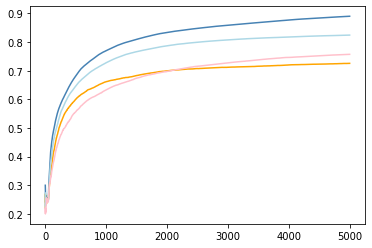

In [143]:
data_deter = np.load("Thompson_Deterministic_4_3.npy")
data_stoch = np.load("Thompson_Stochastic_4_7.npy")
data_epsilon_deter = np.load("EpsilonGreedy_Deterministic_4.npy")[0]
data_epsilon_stoch = np.load("EpsilonGreedy_Stochastic_4.npy")
plt.plot(data_deter, c='steelblue')
plt.plot(data_stoch, c='orange')
plt.plot(data_epsilon_deter, c='lightblue')
plt.plot(data_epsilon_stoch, c='pink')
